# HBOS学习

[因为昨天重装了系统 所以我的conda环境有了点问题 代码类实现出现困难 后期修补后会再改进的~]
HBOS全名为：Histogram-based Outlier Score。它是⼀种单变量⽅法的组合，不能对特征之间的依赖关系进⾏建模，但是计算速度较快，对⼤数据集友好。其基本假设是数据集的每个维度相互独⽴。然后对每个维度进⾏区间(bin)划分，区间的密度越⾼，异常评分越低。

**一、HBOS背景**
在网络安全领域，对异常检测算法的效率要求很高，且输入数据往往非常大，这也是为什么半监督学习的异常检测算法往往采用直方图的原因。如果处理的是高维数据，单维度的直方图很容易计算。大多数直方图相关的算法中，常常固定直方图的宽度或者手动设置宽度。论文提出了一种基于直方图的无监督异常检测算法，并且提出了动态宽度的算法以适应不均衡的长尾分布。
论文来源：Histogram-based Outlier Score (HBOS): A fast Unsupervised Anomaly Detection Algorithm

**二、HBOS简介**
HBOS算法基于多维数据各个维度的独立性假设，对于单个数据维度，先做出数据直方图。对于categroy 值，统计每个值出现的次数，并计算相对频率。对于数值特征，可以用两种方法：
    【1】静态跨度的柱状图：将值域分成K个等宽的桶，落入每个桶的值的频数作为密度的估计（桶的高度）
    【2】动态宽度柱状图：先将所有值排序，然后将连续的N/k个值装进一个桶里，其中N是所有的样例数，k是桶的个数，是一个超参数；柱状图的面积对应桶中的样例数。因为桶的宽度是有桶中第一个值和最后一个值决定的，所有桶的面积都一样，所以，每一个桶的高度可以被计算出来。这意味着跨度大的桶的高度低，即密度小，只有一种情况例外，超过k个数相等，此时一个桶里允许超过N/k个值。

**三、HBOS算法流程：**
1.为每个数据维度做出数据直⽅图。
2.对每个维度都计算了⼀个独⽴的直⽅图，其中每个箱⼦的⾼度表示密度的估计。
检测异常方法：HBOS分值越高，样本越异常

In [1]:
# -*- coding: utf-8 -*-
"""Example of using Histogram- based outlier detection (HBOS) for
outlier detection
"""
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.hbos import HBOS
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train HBOS detector
    clf_name = 'HBOS'
    clf = HBOS()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)


D:\program\Anaconda\Lib\site-packages\pyod\utils\data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)



On Training Data:
HBOS ROC:0.9947, precision @ rank n:0.8

On Test Data:
HBOS ROC:0.9744, precision @ rank n:0.6


<Figure size 1200x1000 with 4 Axes>

# 有关于HBOS类的学习

参数：
n_bins、alpha、tol、contamination。默认：n_bins=10, alpha=0.1, tol=0.5, contamination=0.

输入：
训练数据

函数：
fit训练函数/decision_function精度评定函数

In [ ]:
class HBOS(BaseDetector):
    """Histogram- based outlier detection (HBOS) is an efficient unsupervised
    method. It assumes the feature independence and calculates the degree
    of outlyingness by building histograms. See :cite:`goldstein2012histogram`
    for details.

    Parameters
    ----------
    n_bins : int, optional (default=10)
        The number of bins.

    alpha : float in (0, 1), optional (default=0.1)
        The regularizer for preventing overflow.

    tol : float in (0, 1), optional (default=0.5)
        The parameter to decide the flexibility while dealing
        the samples falling outside the bins.

    contamination : float in (0., 0.5), optional (default=0.1)
        The amount of contamination of the data set,
        i.e. the proportion of outliers in the data set. Used when fitting to
        define the threshold on the decision function.

    Attributes
    ----------
    bin_edges_ : numpy array of shape (n_bins + 1, n_features )
        The edges of the bins.

    hist_ : numpy array of shape (n_bins, n_features)
        The density of each histogram.

    decision_scores_ : numpy array of shape (n_samples,)
        The outlier scores of the training data.
        The higher, the more abnormal. Outliers tend to have higher
        scores. This value is available once the detector is fitted.

    threshold_ : float
        The threshold is based on ``contamination``. It is the
        ``n_samples * contamination`` most abnormal samples in
        ``decision_scores_``. The threshold is calculated for generating
        binary outlier labels.

    labels_ : int, either 0 or 1
        The binary labels of the training data. 0 stands for inliers
        and 1 for outliers/anomalies. It is generated by applying
        ``threshold_`` on ``decision_scores_``.
    """

    def __init__(self, n_bins=10, alpha=0.1, tol=0.5, contamination=0.1):
        super(HBOS, self).__init__(contamination=contamination)
        self.n_bins = n_bins
        self.alpha = alpha
        self.tol = tol

        check_parameter(alpha, 0, 1, param_name='alpha')
        check_parameter(tol, 0, 1, param_name='tol')

    def fit(self, X, y=None):
        """Fit detector. y is ignored in unsupervised methods.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The input samples.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        # validate inputs X and y (optional)
        X = check_array(X)
        self._set_n_classes(y)

        n_samples, n_features = X.shape[0], X.shape[1]
        self.hist_ = np.zeros([self.n_bins, n_features])
        self.bin_edges_ = np.zeros([self.n_bins + 1, n_features])

        # build the histograms for all dimensions
        for i in range(n_features):
            self.hist_[:, i], self.bin_edges_[:, i] = \
                np.histogram(X[:, i], bins=self.n_bins, density=True)
            # the sum of (width * height) should equal to 1
            assert (np.isclose(1, np.sum(
                self.hist_[:, i] * np.diff(self.bin_edges_[:, i])), atol=0.1))

        # outlier_scores = self._calculate_outlier_scores(X)
        outlier_scores = _calculate_outlier_scores(X, self.bin_edges_,
                                                   self.hist_,
                                                   self.n_bins,
                                                   self.alpha, self.tol)

        # invert decision_scores_. Outliers comes with higher outlier scores
        self.decision_scores_ = invert_order(np.sum(outlier_scores, axis=1))
        self._process_decision_scores()
        return self

    def decision_function(self, X):
        """Predict raw anomaly score of X using the fitted detector.

        The anomaly score of an input sample is computed based on different
        detector algorithms. For consistency, outliers are assigned with
        larger anomaly scores.

        Parameters
        ----------
        X : numpy array of shape (n_samples, n_features)
            The training input samples. Sparse matrices are accepted only
            if they are supported by the base estimator.

        Returns
        -------
        anomaly_scores : numpy array of shape (n_samples,)
            The anomaly score of the input samples.
        """
        check_is_fitted(self, ['hist_', 'bin_edges_'])
        X = check_array(X)

        # outlier_scores = self._calculate_outlier_scores(X)
        outlier_scores = _calculate_outlier_scores(X, self.bin_edges_,
                                                   self.hist_,
                                                   self.n_bins,
                                                   self.alpha, self.tol)
        return invert_order(np.sum(outlier_scores, axis=1))


# HBOS代码的复现-基于网页代码

In [1]:

import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler
from pyod.models.hbos import HBOS

if __name__ == '__main__':

    df = pd.read_excel("D:\Sample _Superstore.xls")
    print(df.head(3))

   Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16  Second Class    DV-13045   

     Customer Name    Segment        Country         City  ... Postal Code  \
0      Claire Gute   Consumer  United States    Henderson  ...       42420   
1      Claire Gute   Consumer  United States    Henderson  ...       42420   
2  Darrin Van Huff  Corporate  United States  Los Angeles  ...       90036   

   Region       Product ID         Category Sub-Category  \
0   South  FUR-BO-10001798        Furniture    Bookcases   
1   South  FUR-CH-10000454        Furniture       Chairs   
2    West  OFF-LA-10000240  Office Supplies       Labels   

                                        Product Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.96   

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64


<AxesSubplot:>

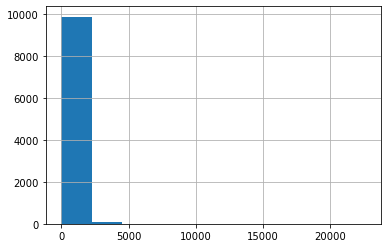

In [2]:
print(df.Sales.describe())
df['Sales'].hist()

In [3]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64


AttributeError: 'Rectangle' object has no property 'normed'

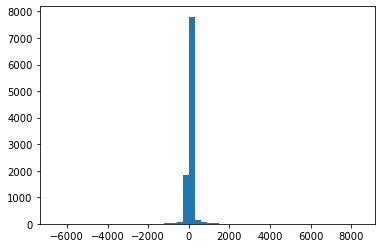

In [4]:
print(df.Profit.describe())
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [9]:
#将Sales和Profit合并成一个两列的numpy数组
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)
X = np.concatenate((X1,X2),axis=1)

outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)

scores_pred = clf.decision_function(X) * -1
        

y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('异常值数量:',n_outliers,'正常值:',n_inliers)

       

异常值数量: 90 正常值: 9904


<Figure size 576x576 with 0 Axes>